In [1]:
# !conda install pytorch torchvision cuda90 -c pytorch -y
# ! pip install qn

In [2]:

%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import torch
from torch.autograd import Variable,grad
from torch import nn, optim
import torch.nn.functional as F
import qn
import numpy as np

import plot
from model import DisNet, GenNet
import sampler
from progress import Progress

def cuda(tensor):
    return tensor.cuda() if torch.cuda.is_available() else tensor

def cpu(tensor):
    return tensor.cpu() if torch.cuda.is_available() else tensor


prog = Progress()
config = qn.load('hyperparams.yml')
batchsize = config['batchsize']
dis_net = cuda(DisNet(config['dim_x']))
gen_net = cuda(GenNet(config['dim_z'],config['dim_x']))

dis_optim = optim.Adam(dis_net.parameters(), lr=config['dis_lr'],
    betas=(config['dis_beta1'],config['dis_beta2']))
gen_optim = optim.Adam(gen_net.parameters(), lr=config['gen_lr'],
    betas=(config['gen_beta1'],config['gen_beta2']))


100 6.653872013092041


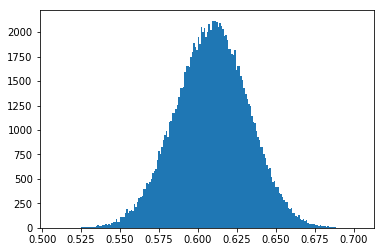

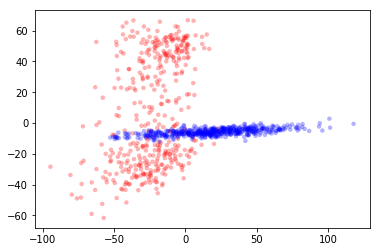

200 6.441758394241333


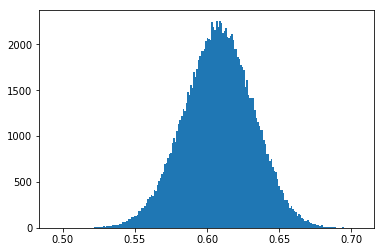

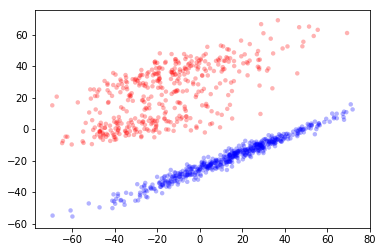

300 6.48618745803833


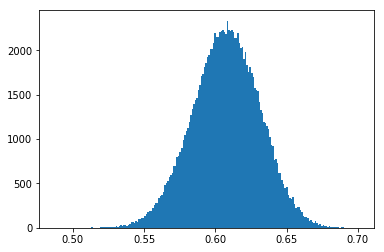

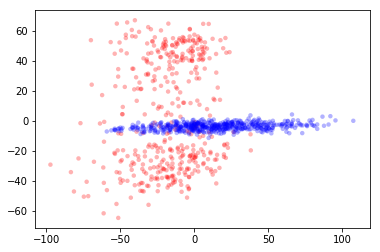

400 6.565229415893555


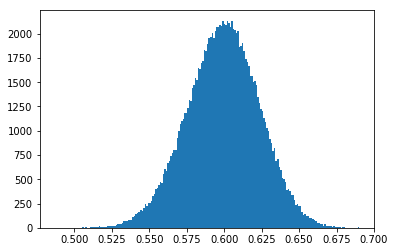

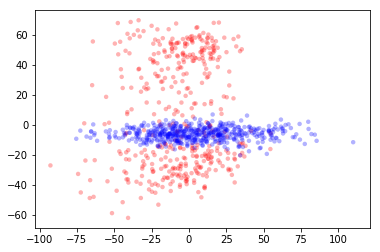

500 6.488421440124512


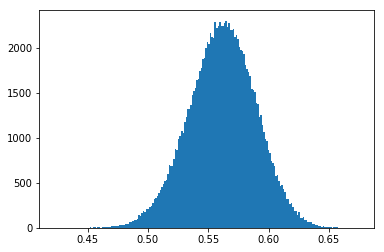

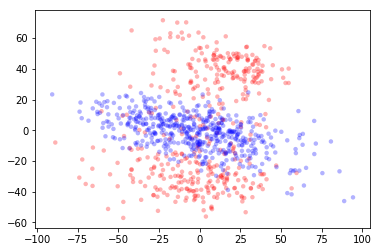

600 6.559154033660889


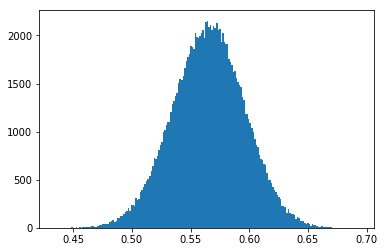

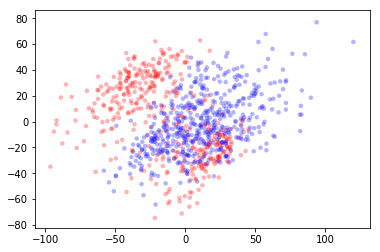

700 6.50127649307251


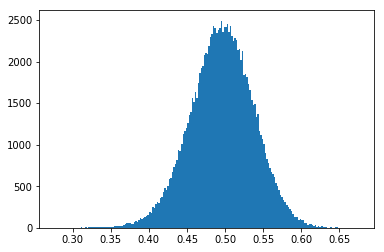

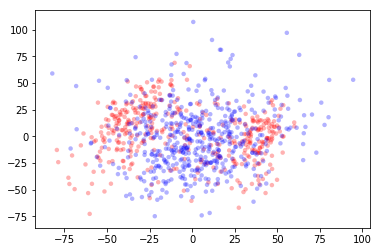

800 6.4941511154174805


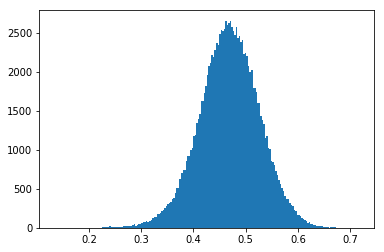

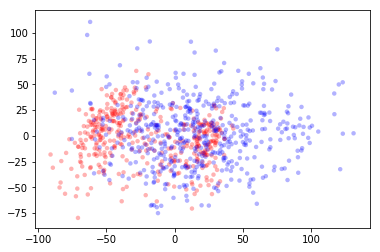

900 6.459230661392212


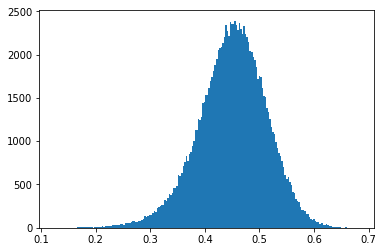

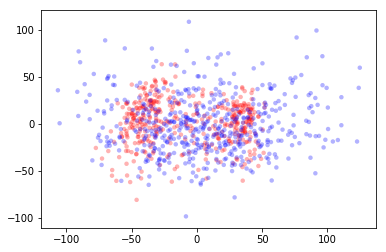

1000 6.472772121429443


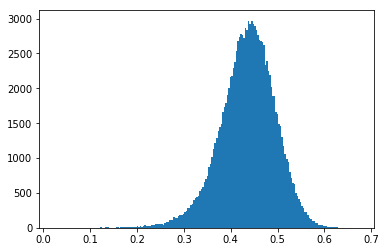

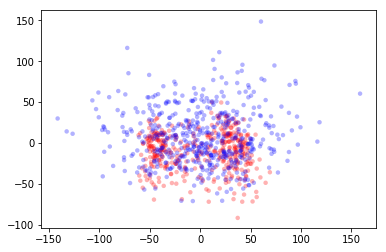

1100 6.44117546081543


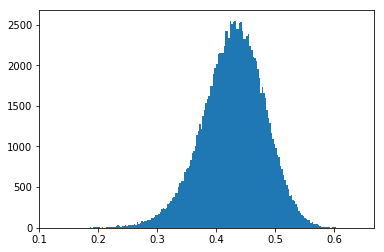

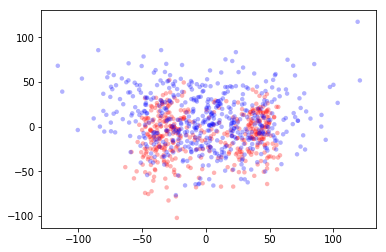

1200 6.511744260787964


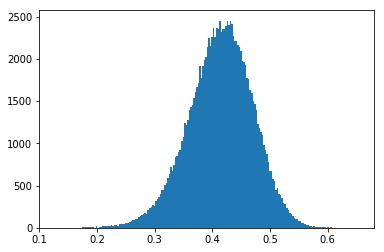

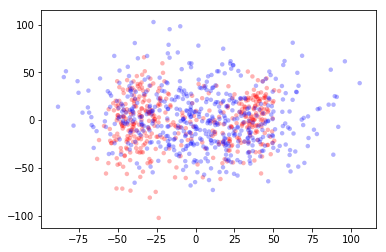

1300 6.492735385894775


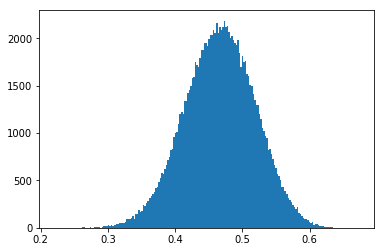

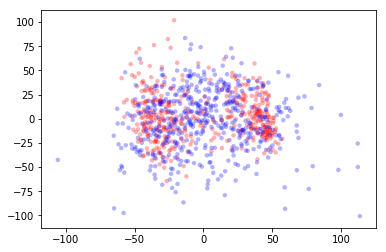

1400 6.471166610717773


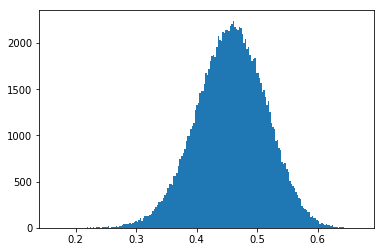

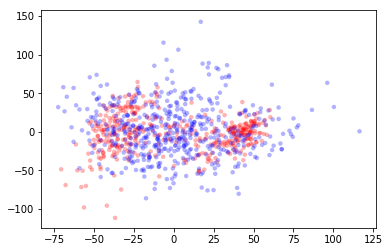

1500 6.4743146896362305


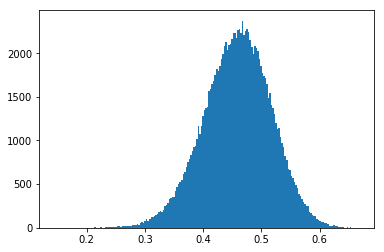

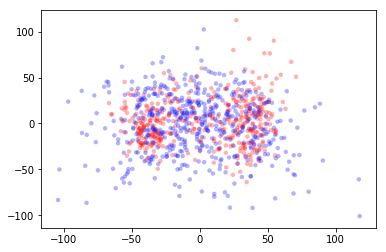

1600 6.448706150054932


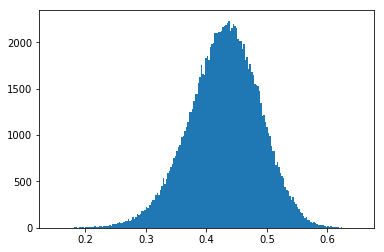

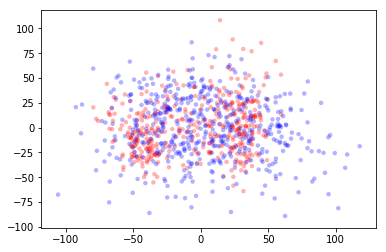

1700 6.498420715332031


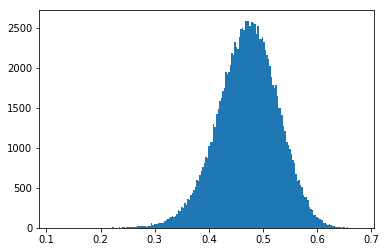

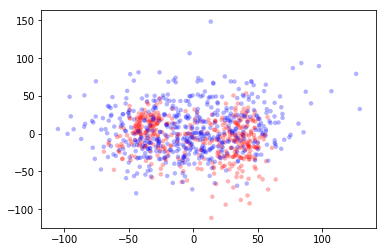

1800 6.5134851932525635


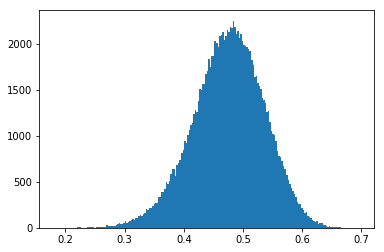

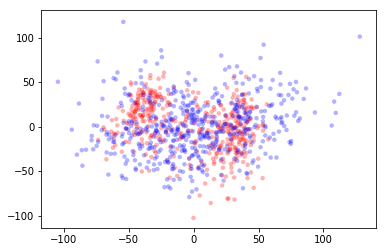

1900 6.48719334602356


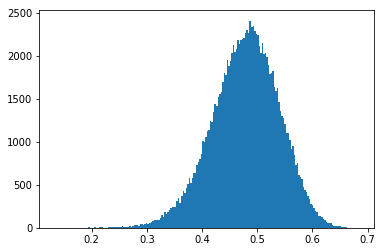

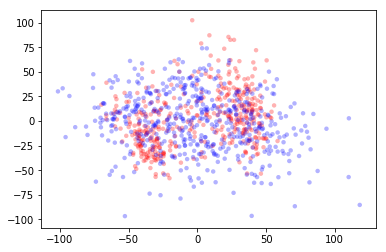

2000 6.435893774032593


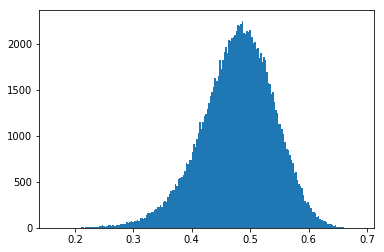

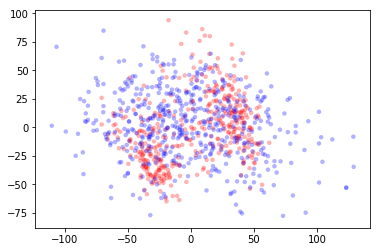

2100 6.4466516971588135


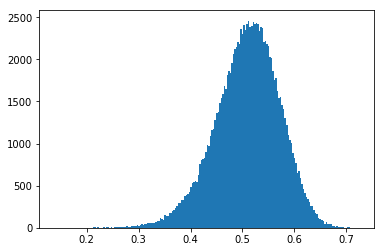

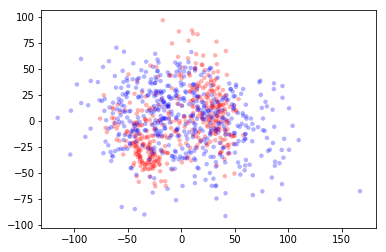

2200 6.4481024742126465


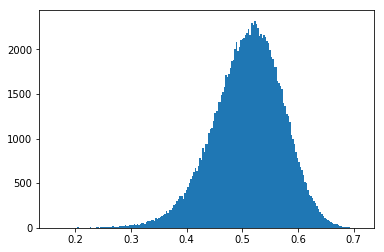

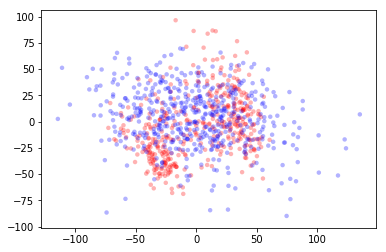

2300 6.640170574188232


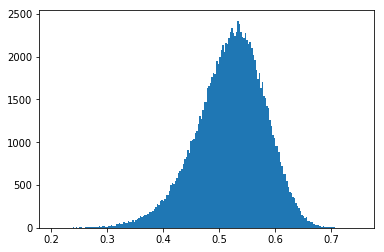

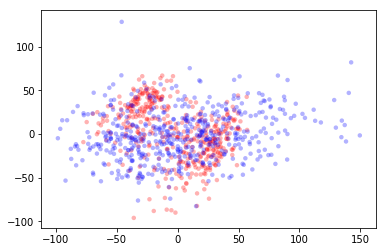

2400 6.51758337020874


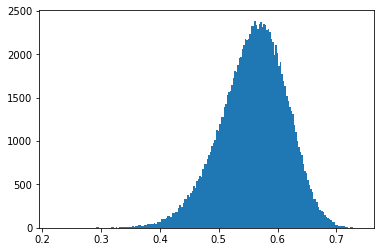

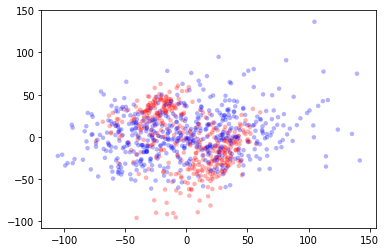

2500 6.486648082733154


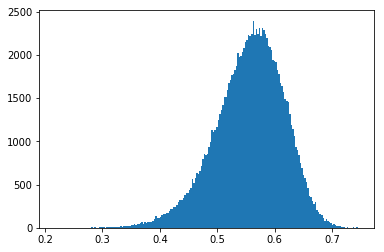

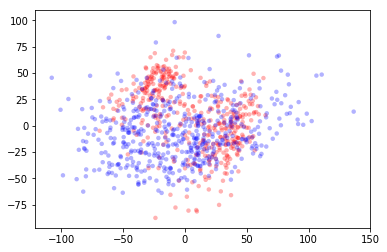

2600 6.636951446533203


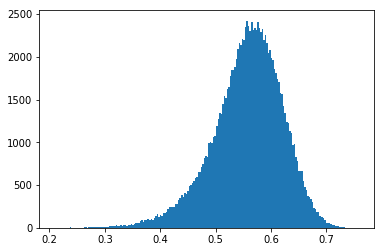

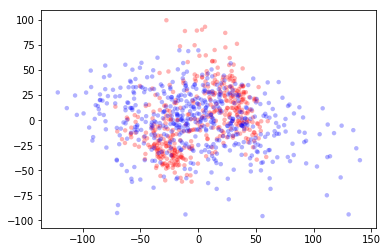

2700 6.406292676925659


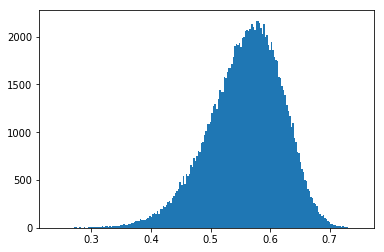

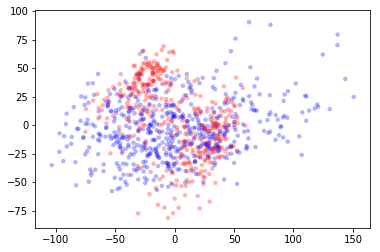

2800 6.425504684448242


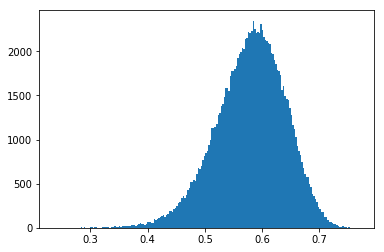

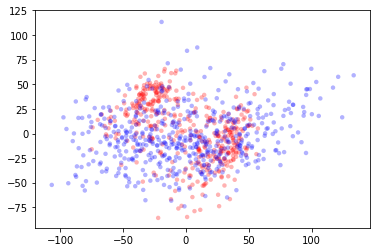

2900 6.42480993270874


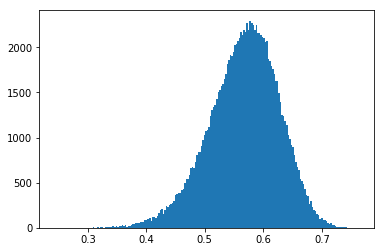

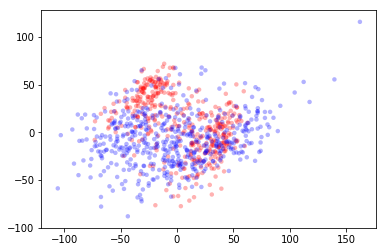

3000 6.424971103668213


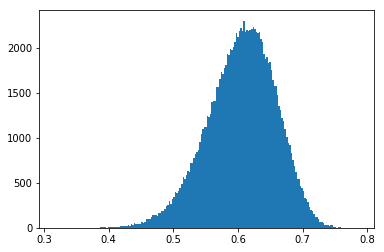

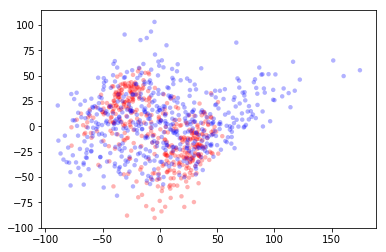

3100 6.459655046463013


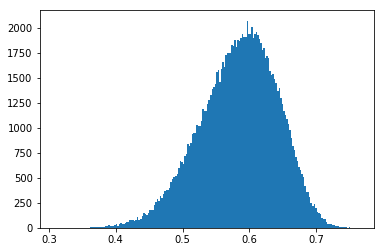

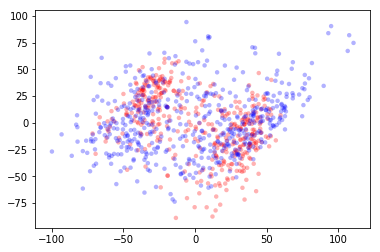

3200 6.443584680557251


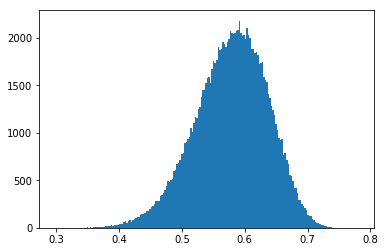

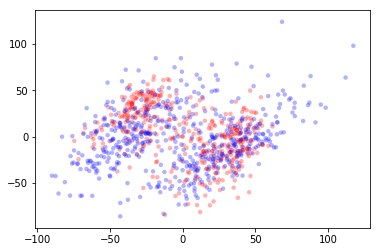

3300 6.405911684036255


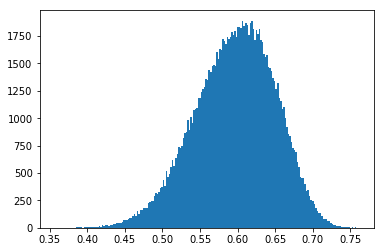

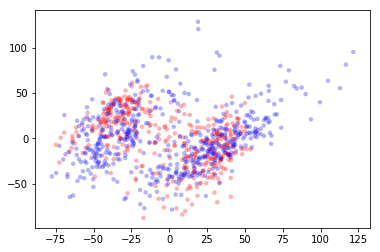

3400 6.431596279144287


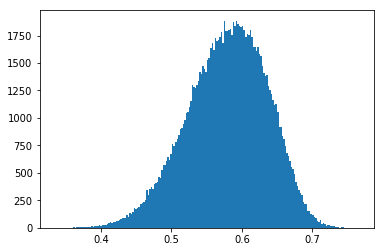

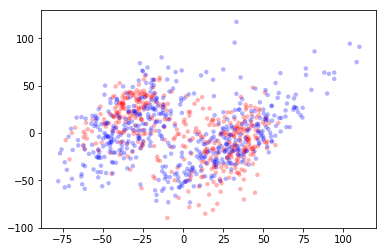

3500 6.431855201721191


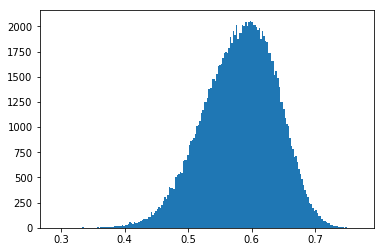

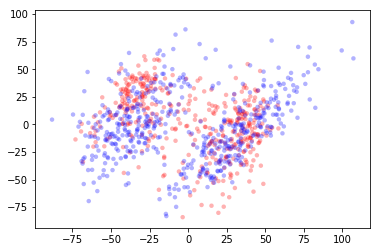

3600 6.427395343780518


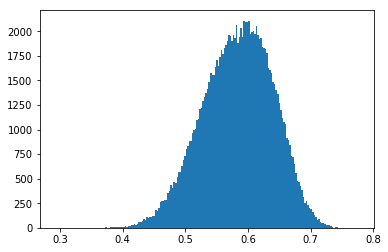

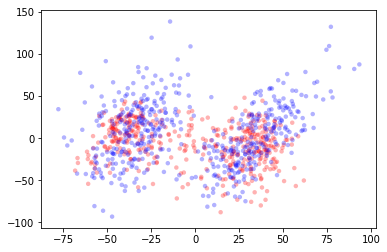

3700 6.439551115036011


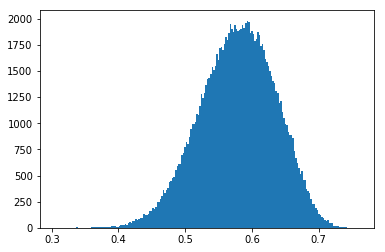

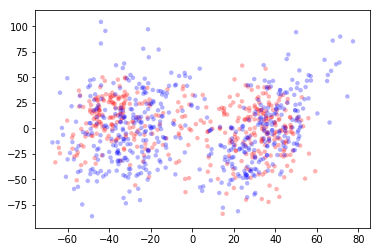

3800 6.442206859588623


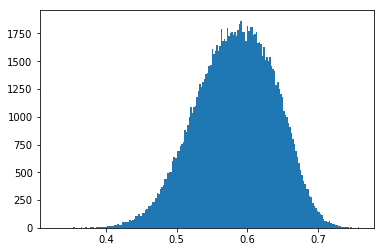

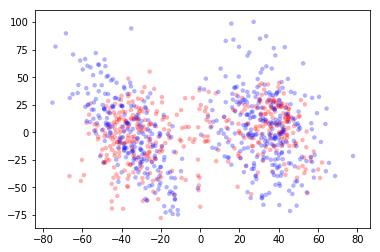

3900 6.41359543800354


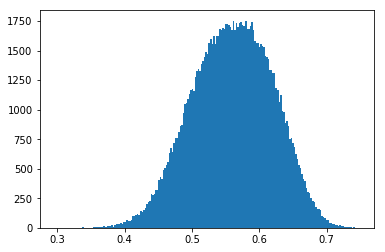

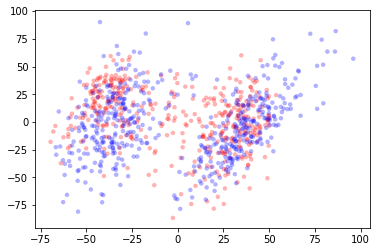

4000 6.441274881362915


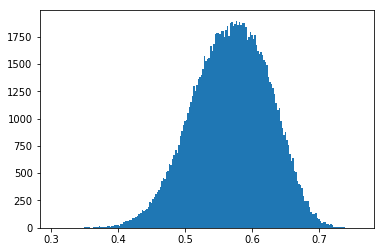

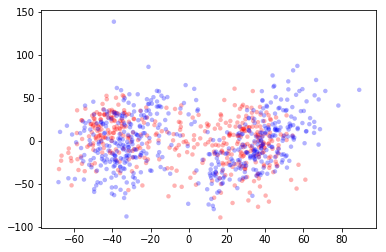

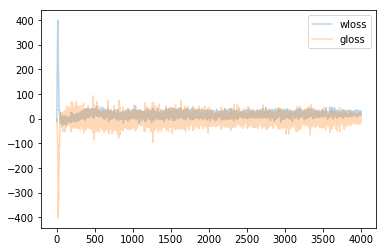

In [4]:
prog.start()
for i in range(config['num_updates']):
    for _ in range(config['num_critic']):
        samples_true_numpy = sampler.sample_x(batchsize)
        samples_true = Variable(cuda(torch.from_numpy(samples_true_numpy)))
        z = sampler.sample_z(batchsize,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = gen_net(z).detach()
        samples_fake_numpy = cpu(samples_fake.data).numpy()      

        eps = np.random.uniform(size=batchsize).astype('float32')
        eps2 = 1 - eps
        # use transpose to broadcast
        samples_mid_numpy = (samples_true_numpy.T*eps).T + \
            (samples_fake_numpy.T*eps2).T
        samples_mid = Variable(cuda(torch.from_numpy(
            samples_mid_numpy)),requires_grad=True)
        f_mid = dis_net(samples_mid)
        # [0]:outputs tuple
        # torch.ones(): grad can be implicitly created only for scalar outputs
        grad_mid = grad(f_mid,samples_mid,cuda(torch.ones(f_mid.size())),
            create_graph=True)[0]
        grad_mid_norm = grad_mid.norm(dim=1)
        diff = (grad_mid_norm - 1).pow(2)

        f_true = dis_net(samples_true)
        f_fake = dis_net(samples_fake)
        loss_critic = f_fake.mean() - f_true.mean() + \
            (config['lda']*diff).mean()
        prog.add_loss_critic(cpu(loss_critic.data).numpy()[0])

        dis_optim.zero_grad()
        loss_critic.backward()
        dis_optim.step()

    prog.add_loss_dis()
    z = sampler.sample_z(batchsize,config['dim_z'])
    z = Variable(cuda(torch.from_numpy(z)))
    samples_fake = gen_net(z)
    f_fake = dis_net(samples_fake)
    loss_gen = -f_fake.mean()
    prog.add_loss_gen(cpu(loss_gen.data).numpy()[0])

    gen_optim.zero_grad()
    loss_gen.backward()
    gen_optim.step()

    if (i+1)%config['num_plot'] == 0:
        print(i+1,prog.duration())
        z = sampler.sample_z(500,config['dim_z'])
        z = Variable(cuda(torch.from_numpy(z)))
        samples_fake = cpu(gen_net(z).data).numpy()
        plot.plot_corr(samples_fake, filename='{}_corr'.format(i+1),show=True)
        plot.plot_scatter(sampler.mat[:,:500].T,samples_fake[:500,:],
            filename='{}_scatter'.format(i+1),show=True)
        if (i+1) > 2000:
            torch.save(dis_net.state_dict(),'temp_models/dis_net_{}.pt'.format(i+1))
            torch.save(gen_net.state_dict(),'temp_models/gen_net_{}.pt'.format(i+1))
        prog.start()
prog.plot()


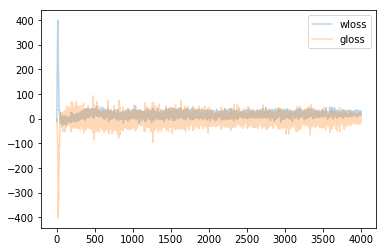

DisNet(
  (fc1): Linear(in_features=6788, out_features=200, bias=True)
  (dp1): Dropout(p=0.5)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (dp2): Dropout(p=0.5)
  (fc3): Linear(in_features=200, out_features=1, bias=True)
)

In [5]:
prog.plot()
dis_net

In [6]:
# torch.save(dis_net.state_dict(),'models/model_1/dis_net.pt')
# torch.save(gen_net.state_dict(),'models/model_1/gen_net.pt')
# !cp model.py models/model_1/